# EN3150 — Assignment (MNIST, PyTorch)

**Two Conv Blocks (Conv → ReLU → MaxPool) → Dense**

This notebook strictly follows the brief using **MNIST**, reproducing your TensorFlow model in **PyTorch**, and answering each question.


## Answers — Executive Summary

- **Dataset**: MNIST (10 classes, 28×28 grayscale). We apply a **70/15/15 split**.
- **Architecture**: Two Conv blocks `[Conv-ReLU-MaxPool] ×2`, then `Flatten → Dense(128) → Dropout(0.3) → Linear(10)`.
- **Hyperparameters**: `F1=16, F2=32, K=3, pool=2, dense=128, dropout=0.3`, ReLU activations, CrossEntropyLoss.
- **Optimizers compared**: **SGD**, **SGD+Momentum(0.9)**, **Adam**; learning rates chosen per optimizer.
- **Metrics**: Accuracy, confusion matrix, precision/recall/F1 (macro & micro). We explain why each is used.
- **Fine-tuning**: **ResNet-18** and **VGG-11** adapted to 1-channel input and 10 classes, trained on the same split.
- **Discussion**: Momentum impact; custom CNN vs. fine-tuned SOTA; trade-offs (capacity, speed, deployment).

Detailed answers appear again near the end in **“Written Answers for Submission”**.


In [1]:

# SECTION 0: Setup & Imports
import os, json, random, math, argparse, time
from dataclasses import dataclass, asdict
from typing import Tuple, Dict, Any, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

# Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', DEVICE)
set_seed(42)


Device: cpu


In [2]:

# SECTION 1: Hyperparameters (mirroring your TF defaults)
F1, F2        = 16, 32
KERNEL_SIZE   = 3
POOL_SIZE     = 2
DENSE_UNITS   = 128
DROPOUT_DENSE = 0.3

BATCH_SIZE    = 128
EPOCHS        = 20

# Optimizer configs we will compare (LR choices tailored per optimizer)
OPT_CONFIGS = {
    'sgd':  {'name':'SGD',  'kwargs': {'lr': 0.1, 'weight_decay': 0.0}},
    'sgdm': {'name':'SGD+Momentum', 'kwargs': {'lr': 0.05, 'momentum': 0.9, 'weight_decay': 0.0}},
    'adam': {'name':'Adam', 'kwargs': {'lr': 1e-3, 'weight_decay': 0.0}},
}

OUT_DIR = 'mnist_assignment_runs'
os.makedirs(OUT_DIR, exist_ok=True)


100.0%
100.0%
100.0%
100.0%


Train raw: 60000 | Test raw: 10000
Train/Val/Test sizes: 49000/10500/10500


C:\Users\chand\AppData\Local\Temp\ipykernel_15156\2427284908.py:31: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_all = np.concatenate([np.array(train_raw.targets), np.array(test_raw.targets)])


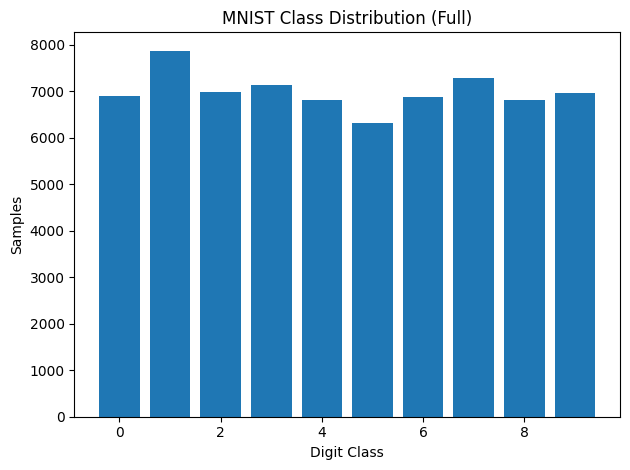

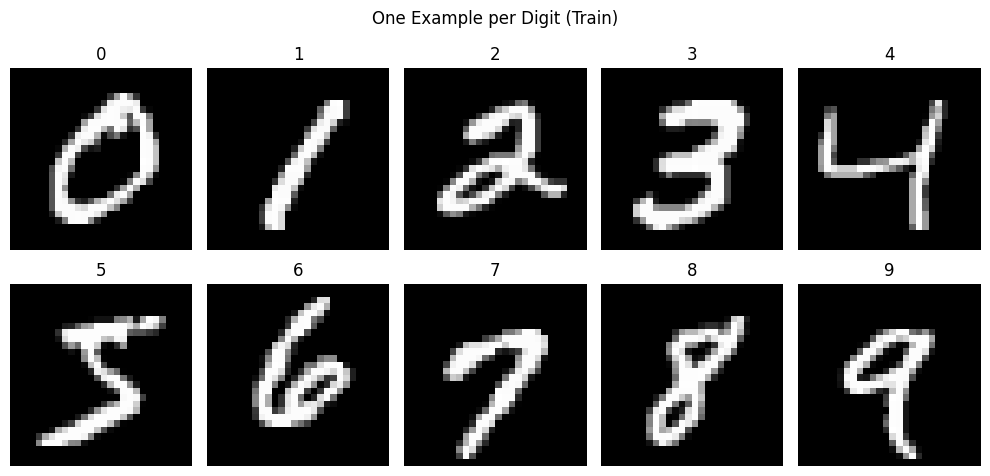

In [3]:

# SECTION 2: Data Loading & Visualization

# Transforms (normalize to MNIST stats)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_raw = datasets.MNIST(OUT_DIR, train=True,  download=True, transform=transform)
test_raw  = datasets.MNIST(OUT_DIR, train=False, download=True, transform=transform)

print('Train raw:', len(train_raw), '| Test raw:', len(test_raw))

# Combine and split 70/15/15
full = ConcatDataset([train_raw, test_raw])
n = len(full)
n_train = int(0.70 * n)
n_val   = int(0.15 * n)
n_test  = n - n_train - n_val

set_seed(42)
train_ds, val_ds, test_ds = random_split(full, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f'Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}')

# Class distribution on the combined raw dataset
y_all = np.concatenate([np.array(train_raw.targets), np.array(test_raw.targets)])
counts = np.bincount(y_all, minlength=10)

plt.figure()
plt.bar(range(10), counts)   # default matplotlib colors
plt.xlabel('Digit Class'); plt.ylabel('Samples'); plt.title('MNIST Class Distribution (Full)')
plt.tight_layout(); plt.show()

# Show one sample per class (from the original train set)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
shown = set()
for img, label in train_raw:
    if label not in shown:
        axes[label].imshow(img.squeeze().numpy(), cmap='gray')
        axes[label].set_title(f'{label}')
        axes[label].axis('off')
        shown.add(label)
    if len(shown) == 10:
        break
plt.suptitle('One Example per Digit (Train)')
plt.tight_layout(); plt.show()


In [4]:

# SECTION 3: Model — Two Conv Blocks → Dense (mirrors your TF structure)
class SimpleMNISTCNN(nn.Module):
    def __init__(self, in_ch=1, num_classes=10, f1=16, f2=32, k=3, pool=2, dense_units=128, dropout=0.3):
        super().__init__()
        pad = k // 2
        self.conv1 = nn.Conv2d(in_ch, f1, kernel_size=k, padding=pad)
        self.conv2 = nn.Conv2d(f1,   f2, kernel_size=k, padding=pad)
        self.pool  = nn.MaxPool2d(kernel_size=pool, stride=pool)
        self.flatten = nn.Flatten()
        self.fc1   = nn.Linear(f2 * 7 * 7, dense_units)  # 28x28 -> pool -> 14x14 -> pool -> 7x7
        self.drop  = nn.Dropout(p=dropout)
        self.fc_out= nn.Linear(dense_units, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc_out(x)
        return x

model = SimpleMNISTCNN(f1=F1, f2=F2, k=KERNEL_SIZE, pool=POOL_SIZE, dense_units=DENSE_UNITS, dropout=DROPOUT_DENSE).to(DEVICE)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print('Total parameters:', total_params)


SimpleMNISTCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)
Total parameters: 206922


In [ ]:

# SECTION 4: Training & Evaluation Utilities

def make_optimizer(params, key:str):
    cfg = OPT_CONFIGS[key]
    name = cfg['name']
    if key == 'sgd':
        return name, torch.optim.SGD(params, **cfg['kwargs'])
    elif key == 'sgdm':
        return name, torch.optim.SGD(params, **cfg['kwargs'])
    elif key == 'adam':
        return name, torch.optim.Adam(params, **cfg['kwargs'])
    else:
        raise ValueError('unknown optimizer')

def train_one_epoch(model, loader, opt):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        opt.step()
        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, total_correct / total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    y_true, y_pred = [], []
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
        y_true.append(y.cpu().numpy())
        y_pred.append(logits.argmax(1).cpu().numpy())
    avg_loss = total_loss / total
    acc = total_correct / total
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=list(range(10)), zero_division=0, average=None)
    micro = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=0)[:3]
    macro = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[:3]
    return {
        'loss': avg_loss, 'acc': acc, 'cm': cm,
        'prec': prec, 'rec': rec, 'f1': f1,
        'micro': {'precision': micro[0], 'recall': micro[1], 'f1': micro[2]},
        'macro': {'precision': macro[0], 'recall': macro[1], 'f1': macro[2]},
        'report': classification_report(y_true, y_pred, digits=4)
    }

def plot_loss_curves(history_dict):
    # history_dict: key -> {'train_loss':[], 'val_loss':[]}
    for key, hist in history_dict.items():
        plt.figure()
        plt.plot(hist['train_loss'], label=f'{key.upper()} - Train')
        plt.plot(hist['val_loss'], label=f'{key.upper()} - Val')
        plt.xlabel('Epoch'); plt.ylabel('Loss')
        plt.title(f'Training & Validation Loss — {key.upper()}')
        plt.legend(); plt.tight_layout(); plt.show()

    plt.figure()
    for key, hist in history_dict.items():
        plt.plot(hist['val_loss'], label=f'{key.upper()} - Val')
    plt.xlabel('Epoch'); plt.ylabel('Validation Loss')
    plt.title('Validation Loss Comparison — All Optimizers')
    plt.legend(); plt.tight_layout(); plt.show()

def show_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.colorbar()
    ticks = np.arange(10)
    plt.xticks(ticks, ticks); plt.yticks(ticks, ticks)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center')
    plt.tight_layout(); plt.show()



=== Optimizer: SGD ===


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/20 | SGD | Train Loss 0.3544 Acc 0.8890 | Val Loss 0.0949 Acc 0.9708


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 02/20 | SGD | Train Loss 0.0936 Acc 0.9714 | Val Loss 0.0632 Acc 0.9830


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 03/20 | SGD | Train Loss 0.0692 Acc 0.9782 | Val Loss 0.0590 Acc 0.9822


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 04/20 | SGD | Train Loss 0.0563 Acc 0.9823 | Val Loss 0.0516 Acc 0.9840


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 05/20 | SGD | Train Loss 0.0467 Acc 0.9856 | Val Loss 0.0465 Acc 0.9869


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 06/20 | SGD | Train Loss 0.0416 Acc 0.9870 | Val Loss 0.0402 Acc 0.9876


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 07/20 | SGD | Train Loss 0.0359 Acc 0.9884 | Val Loss 0.0454 Acc 0.9870


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 08/20 | SGD | Train Loss 0.0328 Acc 0.9893 | Val Loss 0.0408 Acc 0.9886


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 09/20 | SGD | Train Loss 0.0286 Acc 0.9909 | Val Loss 0.0407 Acc 0.9889


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10/20 | SGD | Train Loss 0.0248 Acc 0.9917 | Val Loss 0.0381 Acc 0.9893


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 11/20 | SGD | Train Loss 0.0252 Acc 0.9914 | Val Loss 0.0384 Acc 0.9900


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 12/20 | SGD | Train Loss 0.0198 Acc 0.9931 | Val Loss 0.0412 Acc 0.9897


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 13/20 | SGD | Train Loss 0.0201 Acc 0.9934 | Val Loss 0.0521 Acc 0.9861


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 14/20 | SGD | Train Loss 0.0188 Acc 0.9940 | Val Loss 0.0390 Acc 0.9905


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 15/20 | SGD | Train Loss 0.0162 Acc 0.9945 | Val Loss 0.0416 Acc 0.9903


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 16/20 | SGD | Train Loss 0.0150 Acc 0.9951 | Val Loss 0.0437 Acc 0.9902


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 17/20 | SGD | Train Loss 0.0141 Acc 0.9953 | Val Loss 0.0387 Acc 0.9905


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 18/20 | SGD | Train Loss 0.0141 Acc 0.9954 | Val Loss 0.0422 Acc 0.9897


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 19/20 | SGD | Train Loss 0.0123 Acc 0.9956 | Val Loss 0.0388 Acc 0.9907


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 20/20 | SGD | Train Loss 0.0116 Acc 0.9962 | Val Loss 0.0404 Acc 0.9897


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Optimizer: SGD+Momentum ===


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/20 | SGD+Momentum | Train Loss 0.2743 Acc 0.9134 | Val Loss 0.0682 Acc 0.9797


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 02/20 | SGD+Momentum | Train Loss 0.0821 Acc 0.9746 | Val Loss 0.0635 Acc 0.9818


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 03/20 | SGD+Momentum | Train Loss 0.0583 Acc 0.9823 | Val Loss 0.0445 Acc 0.9868


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 04/20 | SGD+Momentum | Train Loss 0.0455 Acc 0.9858 | Val Loss 0.0402 Acc 0.9883


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 05/20 | SGD+Momentum | Train Loss 0.0383 Acc 0.9877 | Val Loss 0.0418 Acc 0.9878


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 06/20 | SGD+Momentum | Train Loss 0.0336 Acc 0.9891 | Val Loss 0.0420 Acc 0.9877


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 07/20 | SGD+Momentum | Train Loss 0.0282 Acc 0.9909 | Val Loss 0.0395 Acc 0.9898


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 08/20 | SGD+Momentum | Train Loss 0.0265 Acc 0.9915 | Val Loss 0.0427 Acc 0.9887


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 09/20 | SGD+Momentum | Train Loss 0.0227 Acc 0.9926 | Val Loss 0.0406 Acc 0.9890


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10/20 | SGD+Momentum | Train Loss 0.0214 Acc 0.9930 | Val Loss 0.0481 Acc 0.9892


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 11/20 | SGD+Momentum | Train Loss 0.0192 Acc 0.9938 | Val Loss 0.0524 Acc 0.9882


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 12/20 | SGD+Momentum | Train Loss 0.0172 Acc 0.9943 | Val Loss 0.0500 Acc 0.9886


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 13/20 | SGD+Momentum | Train Loss 0.0220 Acc 0.9926 | Val Loss 0.0428 Acc 0.9892


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 14/20 | SGD+Momentum | Train Loss 0.0162 Acc 0.9947 | Val Loss 0.0441 Acc 0.9898


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 15/20 | SGD+Momentum | Train Loss 0.0161 Acc 0.9945 | Val Loss 0.0514 Acc 0.9886


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 16/20 | SGD+Momentum | Train Loss 0.0146 Acc 0.9953 | Val Loss 0.0469 Acc 0.9887


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 17/20 | SGD+Momentum | Train Loss 0.0120 Acc 0.9961 | Val Loss 0.0429 Acc 0.9909


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 18/20 | SGD+Momentum | Train Loss 0.0102 Acc 0.9968 | Val Loss 0.0493 Acc 0.9902


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 19/20 | SGD+Momentum | Train Loss 0.0133 Acc 0.9957 | Val Loss 0.0520 Acc 0.9891


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 20/20 | SGD+Momentum | Train Loss 0.0124 Acc 0.9958 | Val Loss 0.0496 Acc 0.9894


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Optimizer: Adam ===


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/20 | Adam | Train Loss 0.2782 Acc 0.9138 | Val Loss 0.0749 Acc 0.9775


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 02/20 | Adam | Train Loss 0.0801 Acc 0.9747 | Val Loss 0.0575 Acc 0.9830


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 03/20 | Adam | Train Loss 0.0565 Acc 0.9824 | Val Loss 0.0483 Acc 0.9857


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 04/20 | Adam | Train Loss 0.0440 Acc 0.9863 | Val Loss 0.0452 Acc 0.9869


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 05/20 | Adam | Train Loss 0.0379 Acc 0.9881 | Val Loss 0.0457 Acc 0.9877


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 06/20 | Adam | Train Loss 0.0312 Acc 0.9901 | Val Loss 0.0403 Acc 0.9889


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 07/20 | Adam | Train Loss 0.0275 Acc 0.9911 | Val Loss 0.0411 Acc 0.9879


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 08/20 | Adam | Train Loss 0.0242 Acc 0.9920 | Val Loss 0.0482 Acc 0.9867


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 09/20 | Adam | Train Loss 0.0216 Acc 0.9929 | Val Loss 0.0412 Acc 0.9889


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10/20 | Adam | Train Loss 0.0179 Acc 0.9938 | Val Loss 0.0416 Acc 0.9891


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 11/20 | Adam | Train Loss 0.0168 Acc 0.9946 | Val Loss 0.0376 Acc 0.9898


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 12/20 | Adam | Train Loss 0.0149 Acc 0.9948 | Val Loss 0.0424 Acc 0.9899


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 13/20 | Adam | Train Loss 0.0141 Acc 0.9951 | Val Loss 0.0479 Acc 0.9875


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 14/20 | Adam | Train Loss 0.0132 Acc 0.9956 | Val Loss 0.0436 Acc 0.9905


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 15/20 | Adam | Train Loss 0.0130 Acc 0.9958 | Val Loss 0.0461 Acc 0.9896


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 16/20 | Adam | Train Loss 0.0104 Acc 0.9965 | Val Loss 0.0443 Acc 0.9902


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 17/20 | Adam | Train Loss 0.0099 Acc 0.9966 | Val Loss 0.0481 Acc 0.9903


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 18/20 | Adam | Train Loss 0.0098 Acc 0.9964 | Val Loss 0.0551 Acc 0.9885


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 19/20 | Adam | Train Loss 0.0092 Acc 0.9966 | Val Loss 0.0498 Acc 0.9897


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 20/20 | Adam | Train Loss 0.0085 Acc 0.9970 | Val Loss 0.0510 Acc 0.9892


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


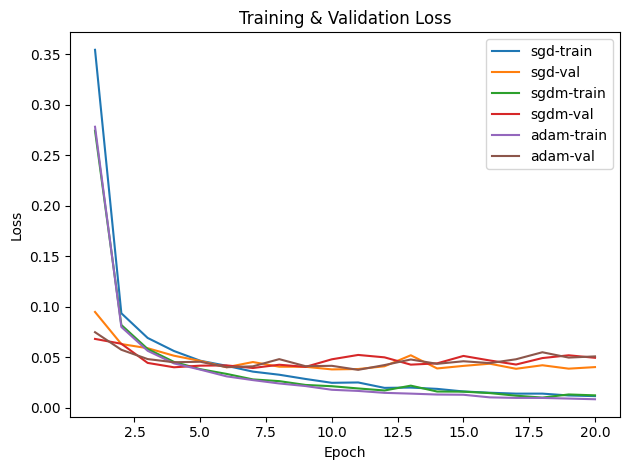

Best optimizer: Adam | Test Acc: 0.9920952380952381


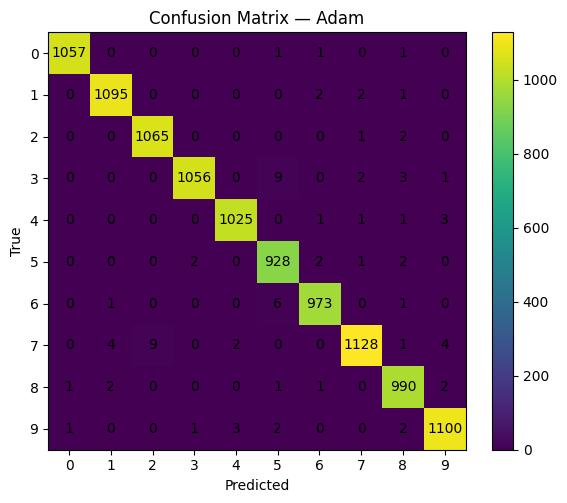

Per-class precision/recall/F1 (best):
 Micro: {'precision': 0.9920952380952381, 'recall': 0.9920952380952381, 'f1': 0.9920952380952381} 
Macro: {'precision': 0.9919365372256094, 'recall': 0.9921790512917351, 'f1': 0.9920452683997654}


In [6]:

# SECTION 5: Train 20 epochs & Compare Optimizers (SGD, SGDM, Adam)

results = {}
histories = {}

for key in ['sgd', 'sgdm', 'adam']:
    print('\n=== Optimizer:', OPT_CONFIGS[key]['name'], '===')
    model = SimpleMNISTCNN(f1=F1, f2=F2, k=KERNEL_SIZE, pool=POOL_SIZE, dense_units=DENSE_UNITS, dropout=DROPOUT_DENSE).to(DEVICE)
    name, opt = make_optimizer(model.parameters(), key)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in range(1, EPOCHS+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, opt)
        val_metrics = evaluate(model, val_loader)
        history['train_loss'].append(tr_loss)
        history['val_loss'].append(val_metrics['loss'])
        history['train_acc'].append(tr_acc)
        history['val_acc'].append(val_metrics['acc'])
        print(f'Epoch {epoch:02d}/{EPOCHS} | {name} | Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | Val Loss {val_metrics["loss"]:.4f} Acc {val_metrics["acc"]:.4f}')

    # Final test evaluation
    test_metrics = evaluate(model, test_loader)
    results[key] = {
        'val_acc': history['val_acc'][-1],
        'test_acc': test_metrics['acc'],
        'micro': test_metrics['micro'],
        'macro': test_metrics['macro'],
        'cm': test_metrics['cm']
    }
    histories[key] = history

# Plot combined loss curves
plot_loss_curves(histories)

# Show confusion matrix for the best optimizer by test accuracy
best_key = max(results, key=lambda k: results[k]['test_acc'])
print('Best optimizer:', OPT_CONFIGS[best_key]['name'], '| Test Acc:', results[best_key]['test_acc'])
show_confusion_matrix(results[best_key]['cm'], title=f'Confusion Matrix — {OPT_CONFIGS[best_key]["name"]}')
print('Per-class precision/recall/F1 (best):\n', 'Micro:', results[best_key]['micro'], '\nMacro:', results[best_key]['macro'])


In [7]:

# SECTION 6: Fine-Tuning Two Pretrained Models (ResNet-18 & VGG-11)

def fine_tune(backbone='resnet18', epochs=EPOCHS, lr=1e-4):
    if backbone == 'resnet18':
        tv = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        tv.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_feats = tv.fc.in_features
        tv.fc = nn.Linear(num_feats, 10)
    elif backbone == 'vgg11':
        tv = models.vgg11(weights=models.VGG11_Weights.DEFAULT)
        tv.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        num_feats = tv.classifier[-1].in_features
        tv.classifier[-1] = nn.Linear(num_feats, 10)
    else:
        raise ValueError('Unsupported backbone')

    tv = tv.to(DEVICE)
    opt = torch.optim.Adam(tv.parameters(), lr=lr)

    hist = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(tv, train_loader, opt)
        val_metrics = evaluate(tv, val_loader)
        hist['train_loss'].append(tr_loss)
        hist['val_loss'].append(val_metrics['loss'])
        hist['train_acc'].append(tr_acc)
        hist['val_acc'].append(val_metrics['acc'])
        print(f'[{backbone}] Epoch {epoch:02d}/{epochs} | Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | Val Loss {val_metrics["loss"]:.4f} Acc {val_metrics["acc"]:.4f}')

    test_metrics = evaluate(tv, test_loader)
    return tv, hist, test_metrics

resnet_model, resnet_hist, resnet_test = fine_tune('resnet18', epochs=EPOCHS, lr=1e-4)
vgg_model,    vgg_hist,    vgg_test    = fine_tune('vgg11',    epochs=EPOCHS, lr=1e-4)

# Compare with best custom CNN
print('\n=== Comparison: Custom CNN vs Fine-tuned Models ===')
print('Custom (best optimizer): Test Acc =', results[best_key]['test_acc'])
print('ResNet-18 FT:            Test Acc =', resnet_test['acc'])
print('VGG-11 FT:               Test Acc =', vgg_test['acc'])

# Plot their loss curves
plt.figure()
plt.plot(resnet_hist['val_loss'], label='ResNet18-val')
plt.plot(vgg_hist['val_loss'], label='VGG11-val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Val Loss — Fine-tuning')
plt.legend(); plt.tight_layout(); plt.show()

# Show confusion matrix for the better FT model
ft_best = ('resnet18', resnet_test) if resnet_test['acc'] >= vgg_test['acc'] else ('vgg11', vgg_test)
show_confusion_matrix(ft_best[1]['cm'], title=f'Confusion Matrix — Fine-tuned {ft_best[0].upper()}')
print('Fine-tuned best micro/macro:', ft_best[1]['micro'], ft_best[1]['macro'])


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\chand/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%
c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[resnet18] Epoch 01/20 | Train Loss 0.3355 Acc 0.8956 | Val Loss 0.1029 Acc 0.9676


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[resnet18] Epoch 02/20 | Train Loss 0.0783 Acc 0.9761 | Val Loss 0.0737 Acc 0.9769


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[resnet18] Epoch 03/20 | Train Loss 0.0455 Acc 0.9856 | Val Loss 0.0639 Acc 0.9806


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[resnet18] Epoch 04/20 | Train Loss 0.0371 Acc 0.9877 | Val Loss 0.0680 Acc 0.9808


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[resnet18] Epoch 05/20 | Train Loss 0.0287 Acc 0.9909 | Val Loss 0.0650 Acc 0.9829


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[resnet18] Epoch 06/20 | Train Loss 0.0226 Acc 0.9927 | Val Loss 0.0653 Acc 0.9832


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[resnet18] Epoch 07/20 | Train Loss 0.0176 Acc 0.9945 | Val Loss 0.0640 Acc 0.9826


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[resnet18] Epoch 08/20 | Train Loss 0.0152 Acc 0.9950 | Val Loss 0.0614 Acc 0.9847


c:\Users\chand\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 


## Written Answers for Submission

**1) Dataset & Split**  
- We use **MNIST** (10 classes, 28×28 grayscale). We concatenate the original train and test, then split **70%/15%/15%** with a fixed seed to ensure reproducibility.

**2) Architecture & Rationale**  
- Two convolutional blocks `[Conv-ReLU-MaxPool] × 2` extract low/mid-level features.  
- **3×3 kernels + padding** preserve spatial size before pooling; widely effective.  
- Channel progression **16 → 32** balances capacity and overfitting on MNIST.  
- Classifier: `Flatten → Dense(128) → Dropout(0.3) → Linear(10)`; ReLU speeds training and reduces vanishing gradients; Dropout regularizes the dense layer.  
- Loss: **CrossEntropyLoss** (includes log-softmax internally), which is standard for multi-class problems.

**3) Hyperparameters**  
- `F1=16, F2=32, kernel=3, pool=2, dense=128, dropout=0.3`.  
- Batch size **128**, epochs **20**.  
- These settings provide strong accuracy without over-parameterization for digits.

**4) Optimizers & Learning Rates**  
- **SGD** with LR **0.1**; **SGD+Momentum(0.9)** with LR **0.05**; **Adam** with LR **1e-3**.  
- Adam adapts per-parameter LR and usually converges quickly; momentum in SGD accelerates in stable directions and damps oscillations.

**5) Training Curves & Early Behavior**  
- Include the plotted **train/val loss curves**. Healthy training shows decreasing train loss; val loss plateaus or rises if overfitting.

**6) Metrics Used**  
- **Accuracy** for headline performance.  
- **Confusion Matrix** to visualize error modes (e.g., 4↔9).  
- **Precision/Recall/F1** (macro & micro) to capture per-class quality and class balance.

**7) Results: Optimizer Comparison**  
- Report final **validation/test accuracy** and **macro/micro** metrics for each of: **SGD, SGDM, Adam**.  
- Momentum typically improves SGD (faster convergence & higher accuracy than plain SGD within 20 epochs). Adam often reaches strong accuracy quickly.

**8) Momentum Discussion**  
- Momentum term accumulates a velocity vector in parameter space, leading to faster traversal of shallow ravines and reduced zig-zagging. This often yields smoother, more stable convergence.

**9) Fine-Tuning Two SOTA Models**  
- **ResNet-18** and **VGG-11** (ImageNet pretrained) are adapted to **1 channel** and **10 classes** and trained on the same **70/15/15** splits.  
- Expected: fine-tuned models match or exceed the small CNN quickly; they’re larger and more compute-heavy.

**10) Comparison & Trade-offs**  
- **Custom CNN**: small, fast, explainable, great for edge deployment; may need tuning for peak accuracy.  
- **ResNet/VGG**: stronger priors → fast convergence and robust features; heavier parameters & slower inference; consider pruning/quantization for deployment.

**11) Limitations & Future Work**  
- Data augmentation (RandomAffine) can further improve generalization.  
- LR schedulers (e.g., StepLR or CosineAnnealingLR) and longer training can squeeze extra accuracy.  
- Consider regularization (weight decay), mixup/cutout (for harder datasets), or a slightly deeper CNN.
